# World University Rankings

### About Dataset

###### This dataset is taken from the site https://www.kaggle.com/ for educational purposes.

https://www.kaggle.com/datasets/mylesoneill/world-university-rankings

### Loading data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [9]:
! pip install catboost

In [10]:
from catboost import CatBoostRegressor

In [11]:
import seaborn as sns
cm = sns.dark_palette("red", as_cmap=True)

In [12]:
! pip install shap

In [13]:
import shap
shap.initjs()

In [14]:
df = pd.read_csv('cwurData.csv')

In [15]:
df.head(5)

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012


### Train, test and validation samples

In [17]:
len(df)

2200

In [18]:
train, test = train_test_split(df,train_size=0.6,random_state=42)

In [19]:
val, test = train_test_split(test,train_size=0.5,random_state=42)

### Define features

In [21]:
train.columns

Index(['world_rank', 'institution', 'country', 'national_rank',
       'quality_of_education', 'alumni_employment', 'quality_of_faculty',
       'publications', 'influence', 'citations', 'broad_impact', 'patents',
       'score', 'year'],
      dtype='object')

In [22]:
X = ['world_rank', 'institution', 'country', 'national_rank',
       'quality_of_education', 'alumni_employment', 'quality_of_faculty',
       'publications', 'influence', 'citations', 'broad_impact', 'patents', 'year']
cat_features = ['institution', 'country']
y = ['score']

In [23]:
parameters = {'cat_features': cat_features,
              'eval_metric' : 'MAPE',
              'learning_rate' : 0.08,
               'random_seed' : 42,
               'verbose' : 100}

In [24]:
model = CatBoostRegressor(**parameters)

In [25]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.0765646	test: 0.0720544	best: 0.0720544 (0)	total: 180ms	remaining: 2m 59s
100:	learn: 0.0048238	test: 0.0056714	best: 0.0056692 (98)	total: 1.3s	remaining: 11.6s
200:	learn: 0.0028532	test: 0.0042970	best: 0.0042970 (200)	total: 2.34s	remaining: 9.29s
300:	learn: 0.0019142	test: 0.0036923	best: 0.0036923 (300)	total: 3.4s	remaining: 7.89s
400:	learn: 0.0013841	test: 0.0034252	best: 0.0034252 (400)	total: 4.46s	remaining: 6.67s
500:	learn: 0.0010463	test: 0.0032718	best: 0.0032717 (498)	total: 5.5s	remaining: 5.48s
600:	learn: 0.0008444	test: 0.0031833	best: 0.0031833 (600)	total: 6.56s	remaining: 4.36s
700:	learn: 0.0007036	test: 0.0031345	best: 0.0031342 (699)	total: 7.65s	remaining: 3.26s
800:	learn: 0.0005976	test: 0.0030972	best: 0.0030969 (798)	total: 8.79s	remaining: 2.18s
900:	learn: 0.0005188	test: 0.0030793	best: 0.0030790 (898)	total: 9.89s	remaining: 1.09s
999:	learn: 0.0004555	test: 0.0030687	best: 0.0030680 (996)	total: 11s	remaining: 0us

bestTest = 0.0030679

### Testing on a test sample

In [27]:
test['score_pred'] = model.predict(test[X])

In [28]:
def error(y_true,y_pred):
  print(mean_absolute_error(y_true,y_pred))
  print(mean_absolute_percentage_error(y_true,y_pred))

In [29]:
error(test['score'],test['score_pred'])

0.24252500128746057
0.004171252079877742


### Error analysis

In [31]:
test['error'] = test['score_pred'] - test['score']

<Axes: >

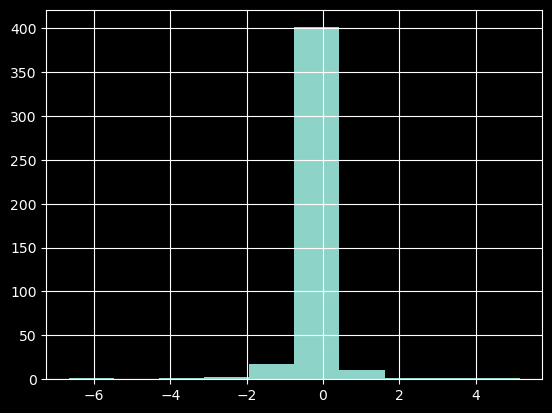

In [32]:
test['error'].hist()

In [33]:
test['error'].mean()

-0.07593784971812031

In [34]:
test['error_abs'] = abs(test['error'])

<Axes: >

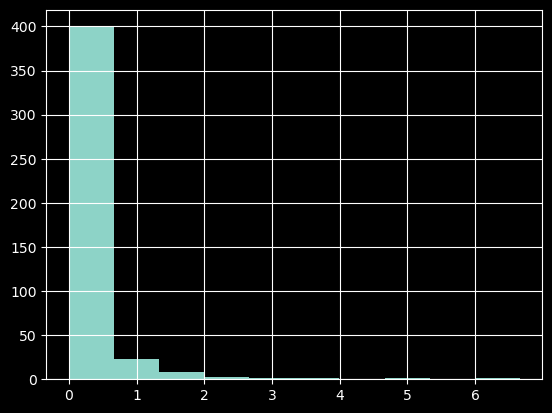

In [35]:
test['error_abs'].hist()

In [36]:
test['error_abs'].describe()

count    440.000000
mean       0.242525
std        0.676369
min        0.000012
25%        0.012616
50%        0.038288
75%        0.136925
max        6.659095
Name: error_abs, dtype: float64

In [37]:
test['score_group'] = pd.qcut(test['score'],5)

In [38]:
t = test.groupby('score_group')[['error_abs','error']].agg(['count','mean'])

C:\Users\Светлана\AppData\Local\Temp\ipykernel_1408\2931417175.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = test.groupby('score_group')[['error_abs','error']].agg(['count','mean'])


In [39]:
t.columns = ['_'.join(col).strip() for col in t.columns.values]

In [40]:
t = t.drop('error_count',axis=1)

In [41]:
t['mean_error_diff'] = t['error_abs_mean'] - test['error_abs'].mean()

In [42]:
t['mean_error'] = test['error_abs'].mean()

In [43]:
t = test.groupby('score')[['error_abs','error']].agg(['count','mean'])

In [44]:
t.columns = ['_'.join(col).strip() for col in t.columns.values]

In [45]:
t = t.drop('error_count',axis=1)

In [46]:
t['mean_error'] = test['error_abs'].mean()

In [47]:
def print_error(col):
  t = test.groupby(col)[['error_abs','error']].agg(['count','mean'])
  t.columns = ['_'.join(col).strip() for col in t.columns.values]
  t = t.drop('error_count',axis=1)
  t['mean_error_diff'] = t['error_abs_mean'] - test['error_abs'].mean()
  t['mean_error'] = test['error_abs'].mean()
  display(t.style.background_gradient(cmap=cm,subset=['mean_error_diff']))

In [48]:
test['world_rank_group'] = pd.qcut(test['world_rank'],10)

In [49]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,world_rank,42.042690
1,quality_of_education,12.222495
2,alumni_employment,9.061909
3,quality_of_faculty,7.194468
4,citations,7.143356
5,year,6.208727
6,influence,6.155085
7,broad_impact,3.651391
8,patents,2.453263
9,publications,2.157527


### Shap

In [51]:
X

['world_rank',
 'institution',
 'country',
 'national_rank',
 'quality_of_education',
 'alumni_employment',
 'quality_of_faculty',
 'publications',
 'influence',
 'citations',
 'broad_impact',
 'patents',
 'year']

In [94]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])

In [96]:
pd.DataFrame(shap_values,columns=X)

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,year
0,-1.021426,0.000172,0.069526,-0.255607,-0.258889,-0.275294,-0.250410,-0.201865,-0.374232,-0.383137,-0.303555,-0.221184,-0.079087
1,-0.982058,-0.003180,-0.031082,0.078801,-0.297927,-0.166625,-0.252968,-0.214782,-0.343212,-0.375567,-0.007469,-0.266590,0.306149
2,-1.196437,-0.000271,0.000407,-0.025448,-0.277803,-0.288653,-0.246876,-0.212491,-0.430030,-0.431182,-0.484776,-0.291095,-0.083774
3,-0.977019,-0.004091,-0.076053,0.076639,-0.333464,-0.329478,-0.249255,-0.072638,-0.394480,-0.421283,-0.043113,-0.014787,0.289237
4,0.710846,0.032361,0.102435,-0.009059,0.885679,0.658459,-0.632131,-0.130471,0.230241,0.261271,-0.490333,-0.068311,-1.360373
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,4.109020,0.013816,0.087523,-0.031265,-0.165317,-0.320618,1.437058,0.246326,0.414422,0.788238,-0.223950,-0.011428,-1.371744
436,7.914752,-0.019379,0.090185,-0.286268,1.170096,-1.831073,2.400059,0.873851,2.213030,2.621970,1.599699,1.762373,1.197705
437,1.717636,-0.033884,0.050071,-0.089924,-0.314818,-0.486273,-0.616405,0.752726,0.770440,1.096424,-0.338406,1.196642,-1.272369
438,-0.787726,-0.005748,0.061872,-0.097501,-0.331958,-0.268792,-0.339870,-0.093844,0.301339,0.231457,0.281614,-0.312118,-0.002406


In [98]:
train['score'].mean()

47.973659090909095

In [100]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], test[X].iloc[0,:])

<Axes: >

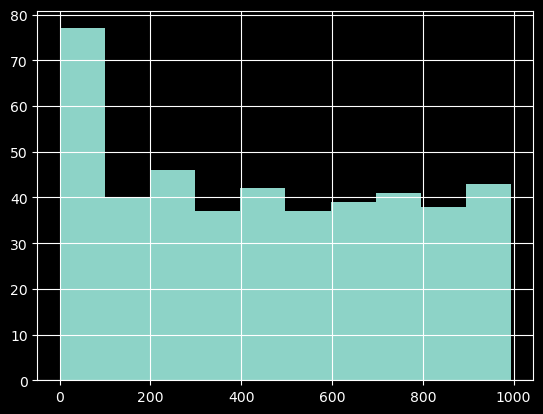

In [102]:
test['world_rank'].hist()

In [104]:
(test['world_rank'] > 50).mean()

0.9113636363636364

In [106]:
shap_cols = [x+'_shap' for x in X]

In [108]:
shap_cols

['world_rank_shap',
 'institution_shap',
 'country_shap',
 'national_rank_shap',
 'quality_of_education_shap',
 'alumni_employment_shap',
 'quality_of_faculty_shap',
 'publications_shap',
 'influence_shap',
 'citations_shap',
 'broad_impact_shap',
 'patents_shap',
 'year_shap']

In [110]:
shap_values_df = pd.DataFrame(shap_values,columns=shap_cols)

In [112]:
shap_values_df

,world_rank_shap,institution_shap,country_shap,national_rank_shap,quality_of_education_shap,alumni_employment_shap,quality_of_faculty_shap,publications_shap,influence_shap,citations_shap,broad_impact_shap,patents_shap,year_shap
0,-1.021426,0.000172,0.069526,-0.255607,-0.258889,-0.275294,-0.250410,-0.201865,-0.374232,-0.383137,-0.303555,-0.221184,-0.079087
1,-0.982058,-0.003180,-0.031082,0.078801,-0.297927,-0.166625,-0.252968,-0.214782,-0.343212,-0.375567,-0.007469,-0.266590,0.306149
2,-1.196437,-0.000271,0.000407,-0.025448,-0.277803,-0.288653,-0.246876,-0.212491,-0.430030,-0.431182,-0.484776,-0.291095,-0.083774
3,-0.977019,-0.004091,-0.076053,0.076639,-0.333464,-0.329478,-0.249255,-0.072638,-0.394480,-0.421283,-0.043113,-0.014787,0.289237
4,0.710846,0.032361,0.102435,-0.009059,0.885679,0.658459,-0.632131,-0.130471,0.230241,0.261271,-0.490333,-0.068311,-1.360373
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,4.109020,0.013816,0.087523,-0.031265,-0.165317,-0.320618,1.437058,0.246326,0.414422,0.788238,-0.223950,-0.011428,-1.371744
436,7.914752,-0.019379,0.090185,-0.286268,1.170096,-1.831073,2.400059,0.873851,2.213030,2.621970,1.599699,1.762373,1.197705
437,1.717636,-0.033884,0.050071,-0.089924,-0.314818,-0.486273,-0.616405,0.752726,0.770440,1.096424,-0.338406,1.196642,-1.272369
438,-0.787726,-0.005748,0.061872,-0.097501,-0.331958,-0.268792,-0.339870,-0.093844,0.301339,0.231457,0.281614,-0.312118,-0.002406


In [114]:
test

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year,score_pred,error,error_abs,score_group,world_rank_group
1825,626,University of Texas at Arlington,USA,185,367,567,218,492,532,511,565.0,462,44.47,2015,44.418674,-0.051326,0.051326,"(44.38, 44.71]","(553.4, 671.2]"
629,430,University of Tampere,Finland,6,355,235,210,554,461,493,370.0,637,45.41,2014,45.417152,0.007152,0.007152,"(44.71, 45.574]","(341.0, 443.5]"
2193,994,Ryerson University,Canada,33,367,567,218,811,969,511,975.0,756,44.03,2015,44.005233,-0.024767,0.024767,"(43.359, 44.38]","(892.1, 994.0]"
636,437,University of Campinas,Brazil,3,355,478,210,297,534,406,386.0,227,45.39,2014,45.423877,0.033877,0.033877,"(44.71, 45.574]","(341.0, 443.5]"
56,57,Rice University,USA,41,28,53,94,101,101,53,NaN,101,48.76,2012,48.164276,-0.595724,0.595724,"(45.574, 48.794]","(0.999, 59.9]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,37,"University of California, Santa Barbara",USA,25,101,101,28,89,91,38,NaN,101,51.67,2013,52.945744,1.275744,1.275744,"(48.794, 100.0]","(0.999, 59.9]"
219,20,"University of California, San Diego",USA,15,32,478,20,16,5,19,16.0,13,68.36,2014,67.680661,-0.679339,0.679339,"(48.794, 100.0]","(0.999, 59.9]"
44,45,"University of California, Davis",USA,33,79,101,92,23,40,25,NaN,32,51.06,2012,50.405521,-0.654479,0.654479,"(48.794, 100.0]","(0.999, 59.9]"
1451,252,Florida State University,USA,96,367,334,218,200,184,136,225.0,411,46.53,2015,46.609980,0.079980,0.079980,"(45.574, 48.794]","(228.7, 341.0]"


In [116]:
test_shap = pd.concat([test.reset_index(),shap_values_df],axis=1)

In [118]:
len(test)

440

In [120]:
test_shap = test_shap.sort_values('error_abs',ascending=False)

In [122]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap[shap_cols].values[0,:], test_shap[X].iloc[0,:])

In [124]:
pd.options.display.max_columns = 100

In [126]:
test_shap

,index,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year,score_pred,error,error_abs,score_group,world_rank_group,world_rank_shap,institution_shap,country_shap,national_rank_shap,quality_of_education_shap,alumni_employment_shap,quality_of_faculty_shap,publications_shap,influence_shap,citations_shap,broad_impact_shap,patents_shap,year_shap
223,211,12,California Institute of Technology,USA,10,6,303,7,48,6,16,24.0,9,85.50,2014,78.840905,-6.659095,6.659095,"(48.794, 100.0]","(0.999, 59.9]",8.640946,-0.023224,0.167686,0.185901,5.900978,-2.112719,5.314582,0.486654,2.636867,4.069044,2.262338,2.134501,1.203691
74,1211,12,California Institute of Technology,USA,10,6,328,7,53,9,19,25.0,13,84.40,2015,77.879842,-6.520158,6.520158,"(48.794, 100.0]","(0.999, 59.9]",8.443283,-0.021116,0.177609,0.164822,5.911396,-2.172720,5.386654,0.487808,2.585635,4.112986,2.248798,2.038899,0.542126
7,20,21,Rockefeller University,USA,15,1,101,16,101,28,96,NaN,101,61.74,2012,66.898788,5.158788,5.158788,"(48.794, 100.0]","(0.999, 59.9]",8.592498,0.028800,0.167642,-0.323021,5.839759,-0.463745,2.825097,-0.258288,1.951788,0.472607,1.076659,0.088851,-1.073520
196,120,21,Hebrew University of Jerusalem,Israel,1,15,101,15,101,96,101,NaN,24,59.98,2013,63.703944,3.723944,3.723944,"(48.794, 100.0]","(0.999, 59.9]",8.383196,-0.001310,0.026906,0.434415,3.604229,-0.551077,3.031404,-0.275503,0.760176,-0.447205,0.397288,1.751199,-1.383436
156,1210,11,Yale University,USA,9,10,26,11,18,8,35,20.0,49,86.61,2015,83.241804,-3.368196,3.368196,"(48.794, 100.0]","(0.999, 59.9]",10.222042,0.002861,0.211458,0.344218,6.530480,2.606311,4.521375,1.251708,2.661819,2.317023,2.578205,1.163874,0.856770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,2065,866,Nanjing Agricultural University,China,54,367,567,218,617,726,812,837.0,601,44.16,2015,44.159597,-0.000403,0.000403,"(43.359, 44.38]","(776.2, 892.1]",-1.104704,-0.000069,-0.030654,-0.019818,-0.286780,-0.287919,-0.249285,-0.213958,-0.398624,-0.439709,-0.486136,-0.212413,-0.083994
64,2073,874,"Royal Veterinary College, University of London",United Kingdom,63,246,567,218,896,550,511,837.0,746,44.16,2015,44.160163,0.000163,0.000163,"(43.359, 44.38]","(776.2, 892.1]",-1.156421,-0.000180,0.005502,-0.026320,-0.157456,-0.295178,-0.251934,-0.238452,-0.383069,-0.451528,-0.442039,-0.329223,-0.087200
418,1084,885,University of Lleida,Spain,35,355,478,210,871,888,609,832.0,637,44.41,2014,44.410147,0.000147,0.000147,"(44.38, 44.71]","(776.2, 892.1]",-1.135839,-0.001366,-0.043744,-0.020141,-0.298111,-0.299403,-0.253639,-0.219472,-0.396410,-0.437668,-0.456944,-0.247528,0.246749
211,1590,391,Jilin University,China,14,220,338,218,239,452,645,375.0,551,45.20,2015,45.199980,-0.000020,0.000020,"(44.71, 45.574]","(341.0, 443.5]",-0.928504,-0.001416,-0.031109,-0.017996,-0.181448,-0.235432,-0.253880,0.002873,-0.333474,-0.445710,-0.049623,-0.237007,-0.060955


In [130]:
print_error('world_rank')

,error_abs_count,error_abs_mean,error_mean,mean_error_diff,mean_error
world_rank,,,,,
1,1,3.290729,-3.290729,3.048204,0.242525
3,1,1.851636,-1.851636,1.609111,0.242525
6,1,1.128944,-1.128944,0.886419,0.242525
8,1,1.304610,1.304610,1.062085,0.242525
11,1,3.368196,-3.368196,3.125671,0.242525
12,3,4.947090,-4.947090,4.704565,0.242525
19,1,2.209605,-2.209605,1.967080,0.242525
20,1,0.679339,-0.679339,0.436814,0.242525
21,2,4.441366,4.441366,4.198841,0.242525


<Axes: >

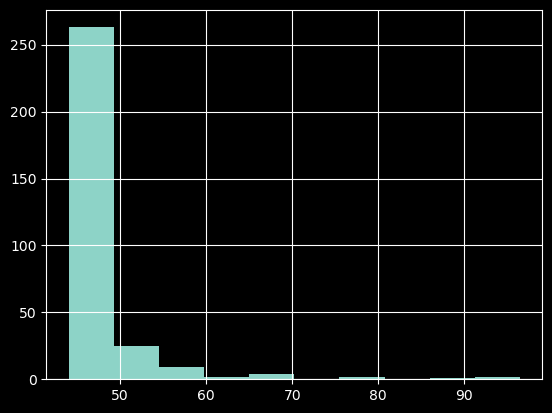

In [160]:
train[(train['world_rank'] )&(train['year'] == 2015)]['score'].hist()

C:\Users\Светлана\AppData\Local\Temp\ipykernel_1408\2533972222.py:1: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  df[(df['world_rank'] )&(train['year'] == 2015)]['score'].hist()


<Axes: >

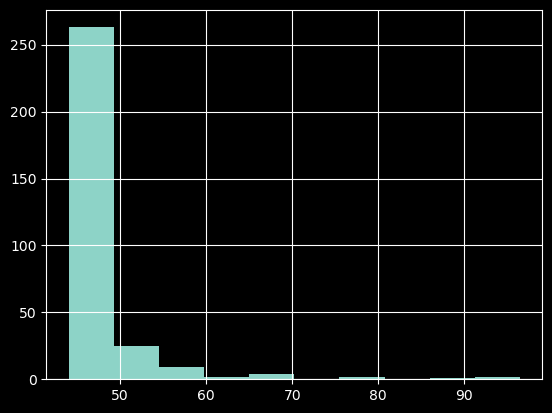

In [158]:
df[(df['world_rank'] )&(train['year'] == 2015)]['score'].hist()

In [162]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap[shap_cols].head(10).values,
                                          test_shap[X].head(10))

In [164]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap[shap_cols].values,
                                          test_shap[X])

In [170]:
train.columns

Index(['world_rank', 'institution', 'country', 'national_rank',
       'quality_of_education', 'alumni_employment', 'quality_of_faculty',
       'publications', 'influence', 'citations', 'broad_impact', 'patents',
       'score', 'year'],
      dtype='object')

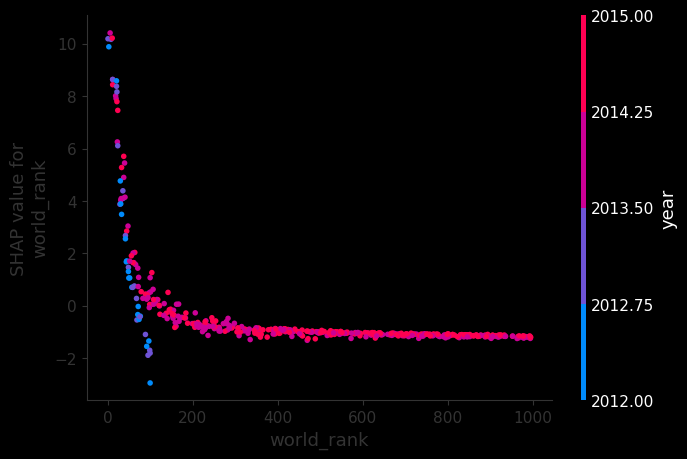

In [168]:
shap.dependence_plot("world_rank", shap_values, test[X])

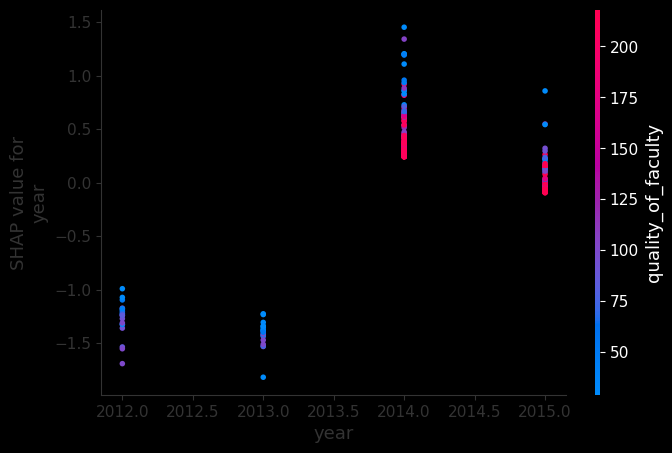

In [166]:
shap.dependence_plot("year", shap_values, test[X])

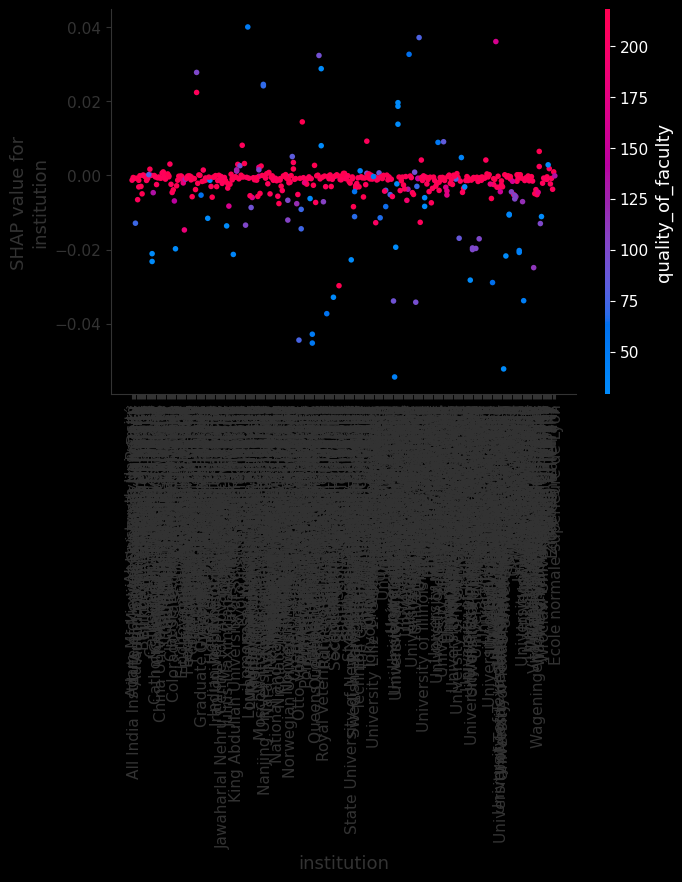

In [172]:
shap.dependence_plot("institution", shap_values, test[X])

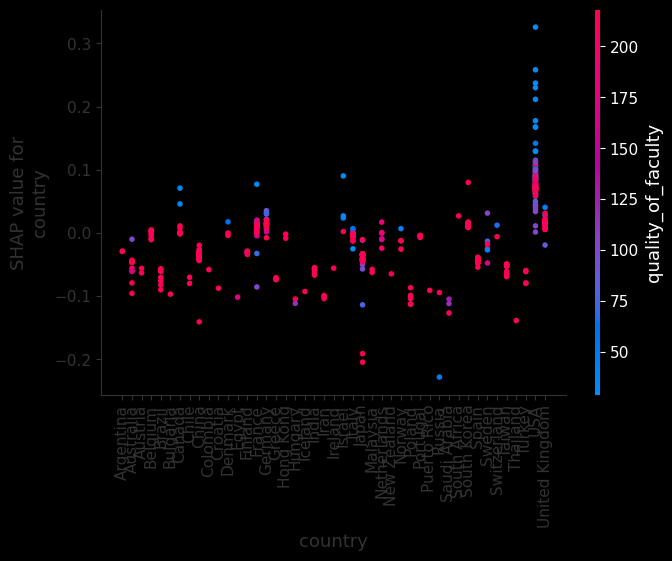

In [174]:
shap.dependence_plot("country", shap_values, test[X])

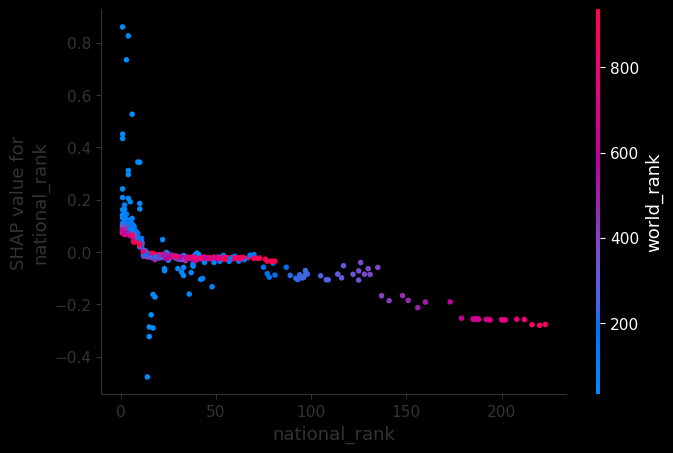

In [176]:
shap.dependence_plot("national_rank", shap_values, test[X])


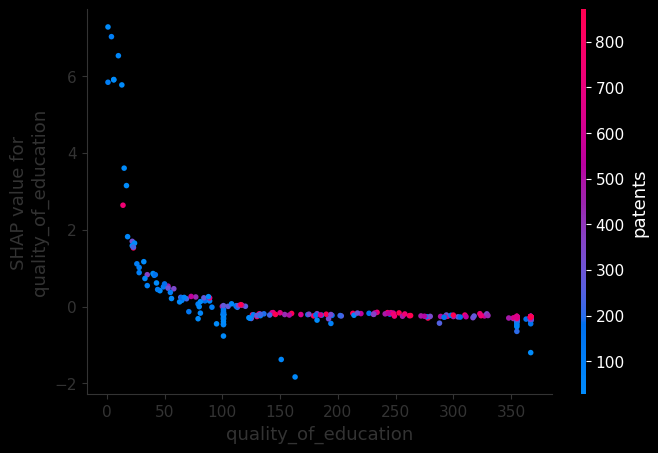

In [178]:
shap.dependence_plot("quality_of_education", shap_values, test[X])

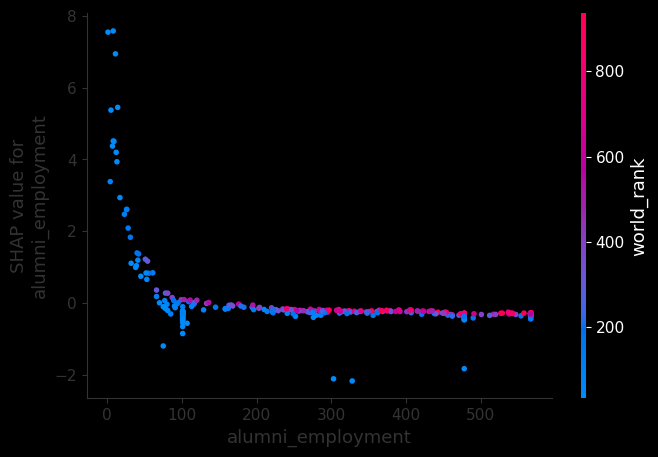

In [180]:
shap.dependence_plot("alumni_employment", shap_values, test[X])

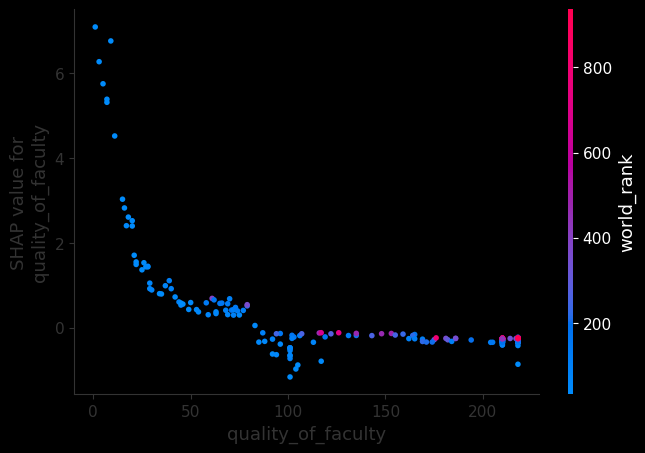

In [182]:
shap.dependence_plot("quality_of_faculty", shap_values, test[X])

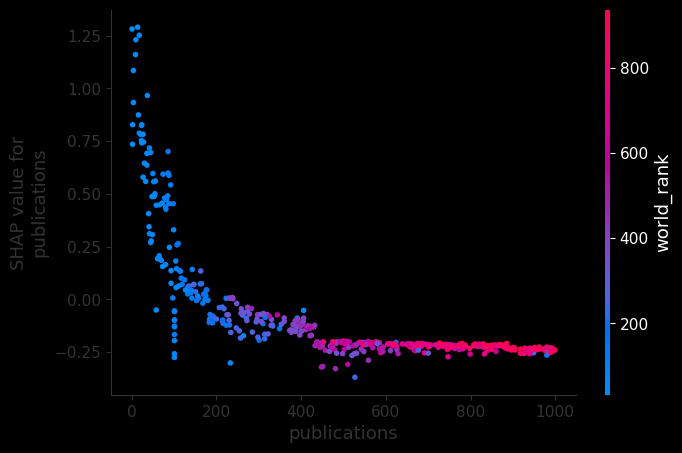

In [184]:
shap.dependence_plot("publications", shap_values, test[X])

In [200]:
test.columns

Index(['world_rank', 'institution', 'country', 'national_rank',
       'quality_of_education', 'alumni_employment', 'quality_of_faculty',
       'publications', 'influence', 'citations', 'broad_impact', 'patents',
       'score', 'year', 'score_pred', 'error', 'error_abs', 'score_group',
       'world_rank_group'],
      dtype='object')

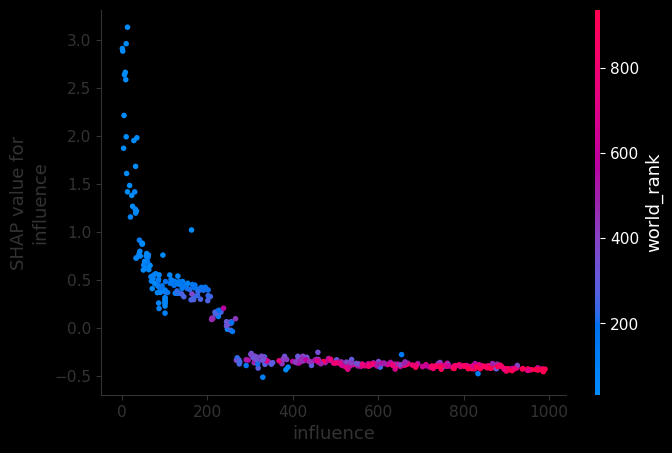

In [188]:
shap.dependence_plot("influence", shap_values, test[X])

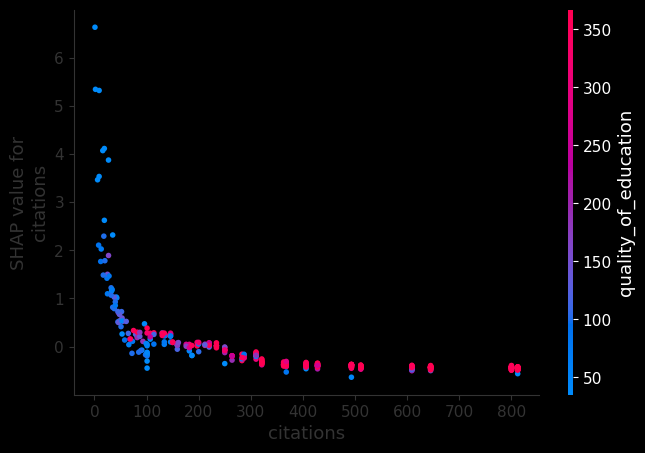

In [190]:
shap.dependence_plot("citations", shap_values, test[X])

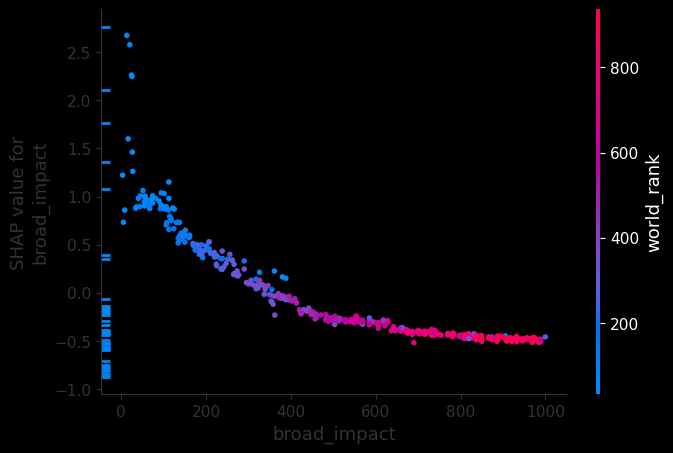

In [192]:
shap.dependence_plot("broad_impact", shap_values, test[X])

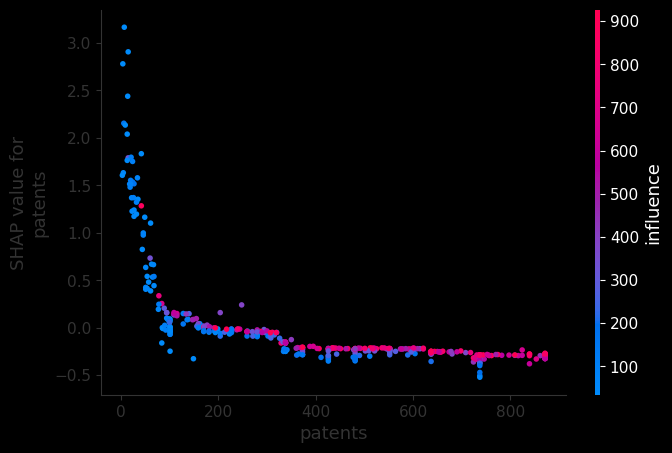

In [194]:
shap.dependence_plot("patents", shap_values, test[X])

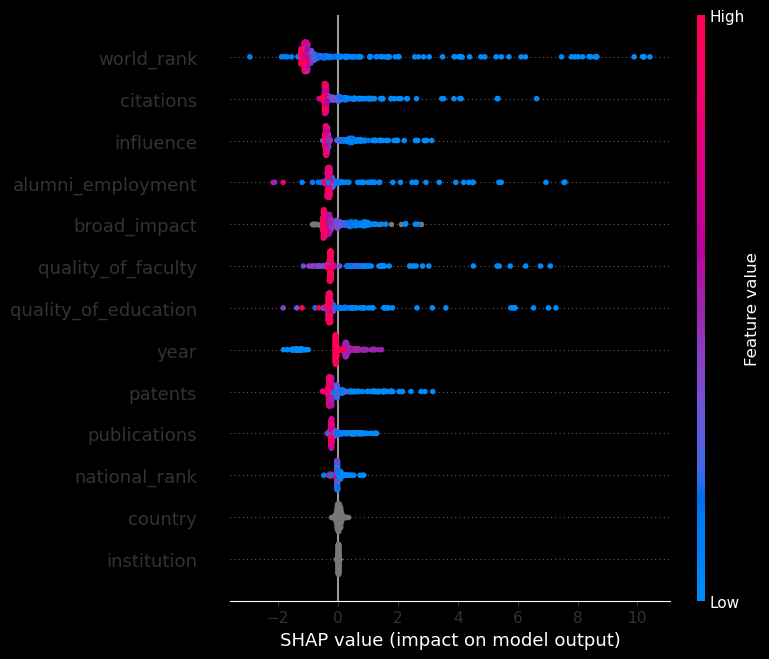

In [204]:
shap.summary_plot(shap_values, test[X])